In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from seq2seq import *
import pickle
from sklearn import metrics

from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seeds(seed):
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Convert a string that simulates a list to a real list
def convert_string_list(element):
    # Delete [] of the string
    element = element[0:len(element)]
    # Create a list that contains each code as e.g. 'A'
    ATC_list = list(element.split('; '))
    for index, code in enumerate(ATC_list):
        # Delete '' of the code
        ATC_list[index] = code[0:len(code)]
    return ATC_list

In [4]:
def multiplicate_rows(df):
    # Duplicate each compound the number of ATC codes associated to it, copying its SMILES in new rows
    new_rows = []
    
    for _, row in df.iterrows():
        atc_codes = row['ATC Codes']
        atc_codes_list = convert_string_list(atc_codes)
        
        if len(atc_codes_list) > 1:
            for code in atc_codes_list:
                if len(code) == 5:
                    new_row = row.copy()
                    new_row['ATC Codes'] = code
                    new_rows.append(new_row)
        else:
            if len(atc_codes_list[0]) == 5:
                new_rows.append(row)
    
    new_set = pd.DataFrame(new_rows)
    new_set = new_set.reset_index(drop=True)

    return new_set

def extract_descriptors(df):
    """
    Extract molecular descriptors from your dataset.
    You'll need to implement this based on your descriptor source.
    
    Returns FloatTensor of shape (n_molecules, descriptor_dimension)
    """
    descriptors = df.iloc[:, 2:-5].values
    # Convert to numpy for easier handling
    if isinstance(descriptors, torch.Tensor):
        desc_array = descriptors.numpy()
    else:
        desc_array = np.array(descriptors)
    
    # Replace infinite values with NaN first
    desc_array[np.isinf(desc_array)] = np.nan
    
    # Calculate median for each feature (column-wise)
    medians = np.nanmedian(desc_array, axis=0)
    
    # Replace NaN values with corresponding median
    for i in range(desc_array.shape[1]):
        mask = np.isnan(desc_array[:, i])
        desc_array[mask, i] = medians[i]
    return torch.tensor(desc_array, dtype=torch.float32)
    
# Create vocabularies
# Tokenize the data
def source(df):
    source = []
    for compound in df['Neutralized SMILES']:
        # A list containing each SMILES character separated
        source.append(list(compound))
    return source
def target(df):
    target = []
    for codes in df['ATC Codes']:  
        code = convert_string_list(codes) 
        # A list of lists, each one containing each ATC code character separated 
        for c in code:
            list_c = list(c)
            target.append(list_c)
    return target

In [5]:
set_seeds(78)

train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")
test_set = pd.read_csv("test_set.csv")

train_set_meta = pd.concat([train_set, val_set])
train_set_meta = shuffle(train_set_meta, random_state = 42)
train_set_meta = train_set_meta.reset_index(drop=True)

new_train_set = multiplicate_rows(train_set_meta)
new_test_set = multiplicate_rows(test_set)

train_descriptors = extract_descriptors(new_train_set)
train_descriptors2 = extract_descriptors(train_set_meta)
test_descriptors = extract_descriptors(new_test_set)
test_descriptors2 = extract_descriptors(test_set)

scaler = StandardScaler()
train_descriptors = torch.tensor(scaler.fit_transform(train_descriptors.numpy()), dtype=torch.float32)
train_descriptors2 = torch.tensor(scaler.transform(train_descriptors2.numpy()), dtype=torch.float32)
test_descriptors = torch.tensor(scaler.transform(test_descriptors.numpy()), dtype=torch.float32)
test_descriptors2 = torch.tensor(scaler.transform(test_descriptors2.numpy()), dtype=torch.float32)

source_train = source(new_train_set)
source_train2 = source(train_set_meta)
source_test = source(new_test_set)
# Test set without duplicated compounds
source_test2 = source(test_set)

target_train = target(new_train_set)
target_test = target(new_test_set)

# An Index object represents a mapping from the vocabulary to integers (indices) to feed into the models
source_index = torch.load("source_index.pt", weights_only=False)
target_index = torch.load("target_index.pt", weights_only=False)

# Create tensors
X_train = source_index.text2tensor(source_train)
X_train2 = source_index.text2tensor(source_train2)
y_train = target_index.text2tensor(target_train)    
X_test = source_index.text2tensor(source_test)
X_test2 = source_index.text2tensor(source_test2)
y_test = target_index.text2tensor(target_test)

if torch.cuda.is_available():
    X_train = X_train.to("cuda")
    X_train2 = X_train2.to("cuda")
    y_train = y_train.to("cuda")
    train_descriptors = train_descriptors.to("cuda") 
    train_descriptors2 = train_descriptors2.to("cuda") 
    test_descriptors = test_descriptors.to("cuda")
    test_descriptors2 = test_descriptors2.to("cuda")
    X_test= X_test.to("cuda")
    y_test = y_test.to("cuda")
    X_test2 = X_test2.to("cuda")

model = pickle.load(open("model_multimodalbiLSTM.pkl", 'rb'))
model.to("cuda")
loss, error_rate = model.evaluate(X_test, test_descriptors, y_test, batch_size = 32) 

In [6]:
torch.cuda.empty_cache()

In [7]:
b_width = 10
predictions, log_probabilities = search_algorithms.multimodal_beam_search(
    model, 
    X_train2,
    train_descriptors2,
    predictions = 6, # max length of the predicted sequence
    beam_width = b_width,
    batch_size = 32, 
    progress_bar = 0
)
output_beam = [target_index.tensor2text(p) for p in predictions]

In [8]:
output_beam

[['<START>M03AC<END>',
  '<START>A02AC<END>',
  '<START>N03AC<END>',
  '<START>B02AC<END>',
  '<START>A02AB<END>',
  '<START>M03AB<END>',
  '<START>A03AC<END>',
  '<START>B01AC<END>',
  '<START>S01EA<END>',
  '<START>A01AC<END>'],
 ['<START>N05CA<END>',
  '<START>N05CB<END>',
  '<START>N05CM<END>',
  '<START>N03AA<END>',
  '<START>N05CD<END>',
  '<START>N01AF<END>',
  '<START>N05CR<END>',
  '<START>N05BA<END>',
  '<START>N03AD<END>',
  '<START>N05DA<END>'],
 ['<START>D07AB<END>',
  '<START>S01BA<END>',
  '<START>S01CA<END>',
  '<START>D07XB<END>',
  '<START>S01CB<END>',
  '<START>R01AD<END>',
  '<START>D07CB<END>',
  '<START>D07XA<END>',
  '<START>D07CA<END>',
  '<START>R03AB<END>'],
 ['<START>A11HA<END>',
  '<START>L01XX<END>',
  '<START>A05AD<END>',
  '<START>J05AF<END>',
  '<START>J05AR<END>',
  '<START>J04AM<END>',
  '<START>J01XX<END>',
  '<START>J05AM<END>',
  '<START>S01AA<END>',
  '<START>J04AF<END>'],
 ['<START>C10AX<END>',
  '<START>C10BX<END>',
  '<START>C10AD<END>',
  '<STA

In [9]:
def metrics_calc(output_beam, df, k):
    f1s = []
    for i, preds in enumerate(output_beam):
        ground_truth = convert_string_list(df['ATC Codes'][i])
        binary_predictions = []
        binary_ground_truth = []
        clean_preds = []
        for pred in preds[0:k]:
            p = pred[7:-5]
            clean_preds.append(p)
        set_pred_gt = list(set(clean_preds + ground_truth))
        for code in set_pred_gt:
            if code in clean_preds:
                binary_predictions.append(1)
            else:
                binary_predictions.append(0)
            if code in ground_truth:
                binary_ground_truth.append(1)
            else:
                binary_ground_truth.append(0)    
        f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    return f1s

In [10]:
f1s1 = metrics_calc(output_beam, train_set_meta, 1)
f1s2 = metrics_calc(output_beam, train_set_meta, 2)
f1s3 = metrics_calc(output_beam, train_set_meta, 3)
f1s4 = metrics_calc(output_beam, train_set_meta, 4)
f1s5 = metrics_calc(output_beam, train_set_meta, 5)
f1s6 = metrics_calc(output_beam, train_set_meta, 6)
f1s7 = metrics_calc(output_beam, train_set_meta, 7)
f1s8 = metrics_calc(output_beam, train_set_meta, 8)
f1s9 = metrics_calc(output_beam, train_set_meta, 9)
f1s10 = metrics_calc(output_beam, train_set_meta, 10)

In [11]:
f1 = pd.DataFrame(columns=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
f1["1"] = f1s1
f1["2"] = f1s2
f1["3"] = f1s3
f1["4"] = f1s4
f1["5"] = f1s5
f1["6"] = f1s6
f1["7"] = f1s7
f1["8"] = f1s8
f1["9"] = f1s9
f1["10"] = f1s10

In [12]:
print(sum(f1s3)/len(f1s3))

0.4285171369729189


In [13]:
f1

,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
1,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2,0.666667,0.500000,0.400000,0.666667,0.571429,0.500000,0.444444,0.400000,0.363636,0.333333
3,0.666667,0.500000,0.400000,0.333333,0.285714,0.500000,0.444444,0.400000,0.363636,0.333333
4,0.000000,0.000000,0.000000,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
...,...,...,...,...,...,...,...,...,...,...
2556,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2557,0.500000,0.800000,0.666667,0.571429,0.500000,0.666667,0.600000,0.545455,0.500000,0.461538
2558,1.000000,0.666667,0.500000,0.400000,0.333333,0.285714,0.250000,0.222222,0.200000,0.181818
2559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
col_max_por_fila = f1.idxmax(axis=1)
filas_todo_cero = (f1 == 0.0).all(axis=1)
col_max_por_fila[filas_todo_cero] = '0'

In [15]:
col_max_por_fila.tolist()

['1',
 '1',
 '1',
 '1',
 '4',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '3',
 '2',
 '7',
 '1',
 '1',
 '1',
 '0',
 '1',
 '2',
 '1',
 '0',
 '1',
 '2',
 '5',
 '1',
 '2',
 '1',
 '1',
 '1',
 '2',
 '1',
 '7',
 '2',
 '2',
 '2',
 '3',
 '1',
 '2',
 '1',
 '3',
 '2',
 '10',
 '3',
 '6',
 '1',
 '1',
 '1',
 '5',
 '1',
 '1',
 '5',
 '1',
 '6',
 '1',
 '1',
 '1',
 '1',
 '1',
 '4',
 '0',
 '0',
 '1',
 '7',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '3',
 '1',
 '1',
 '2',
 '1',
 '5',
 '1',
 '1',
 '2',
 '2',
 '4',
 '1',
 '1',
 '2',
 '1',
 '0',
 '1',
 '1',
 '5',
 '1',
 '2',
 '1',
 '1',
 '3',
 '0',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '4',
 '1',
 '1',
 '2',
 '3',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '5',
 '1',
 '1',
 '1',
 '10',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '3',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '8',
 '1',
 '1',
 '2',
 '2',
 '1',
 '0',
 '1',
 '3',
 '1',
 '0',
 '1',
 '3',
 '1',
 '0',
 '1',
 '1',
 '2',
 '2',
 '

In [16]:
log_probabilities[5]

tensor([-2.1820, -2.4816, -2.5299, -3.2077, -3.7678, -3.8059, -4.0278, -4.0664,
        -4.1910, -4.2127], device='cuda:0')

In [17]:
X = log_probabilities.cpu().numpy()
y = np.array(col_max_por_fila, dtype=np.float32)

In [18]:
X.shape

(2561, 10)

In [19]:
from keras import backend as K
import gc
K.clear_session()
gc.collect()

0

In [20]:
nn = Sequential([
    (Dense(1, input_dim = X.shape[1], activation = 'linear'))
])
# nn = Sequential([ 
#     Dense(64, input_dim=X.shape[1], activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1, activation='linear')
# ])
# Compile the model
nn.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['mae']
)

# Define early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True, verbose = 1)

# Train the model
history = nn.fit(
    X, 
    y, 
    epochs = 5000, 
    batch_size = 64,
    validation_split = 0.15,
    callbacks = [callback], 
    verbose = 0
)

C:\Users\trini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1840: early stopping
Restoring model weights from the end of the best epoch: 1835.


In [21]:
pickle.dump(nn, open('meta-model_multimodalbiLSTM.pkl','wb'))

In [22]:
b_width = 10
predictions_test, log_probabilities_test = search_algorithms.multimodal_beam_search(
    model, 
    X_test2, # Make predictions with test set
    test_descriptors2,
    predictions = 6, # max length of the predicted sequence
    beam_width = b_width,
    batch_size = 32, 
    progress_bar = 0
)
output_beam_test = [target_index.tensor2text(p) for p in predictions_test]

In [23]:
y_pred = nn.predict(log_probabilities_test.cpu().numpy())

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


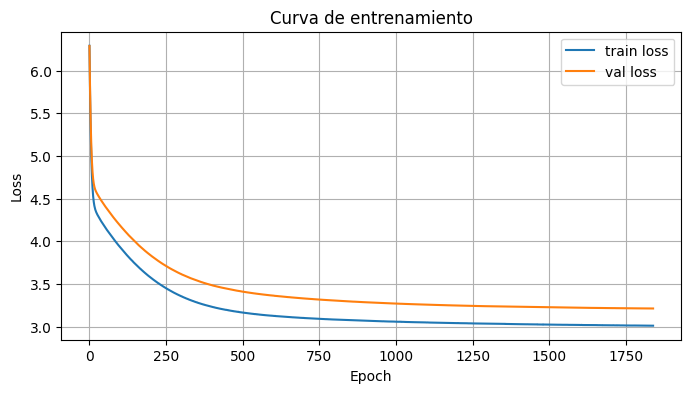

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curva de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
y_pred

array([[2.2685728 ],
       [0.8882888 ],
       [1.5256381 ],
       [2.064125  ],
       [2.0377798 ],
       [2.2220705 ],
       [1.417628  ],
       [1.7236943 ],
       [2.0329475 ],
       [2.0890732 ],
       [2.0827007 ],
       [1.4673519 ],
       [1.8631928 ],
       [2.3221614 ],
       [2.2701597 ],
       [1.7825861 ],
       [1.8851361 ],
       [2.2144356 ],
       [2.1686058 ],
       [1.3539138 ],
       [1.4933267 ],
       [1.0291495 ],
       [1.1953111 ],
       [2.2202234 ],
       [1.443757  ],
       [1.5418746 ],
       [0.9014748 ],
       [1.815371  ],
       [2.0913854 ],
       [2.4079208 ],
       [1.7315223 ],
       [2.0023892 ],
       [2.3729231 ],
       [2.2699888 ],
       [2.0832329 ],
       [1.4547231 ],
       [1.784163  ],
       [1.0849824 ],
       [1.290242  ],
       [2.3554056 ],
       [2.0402546 ],
       [1.9737563 ],
       [2.42141   ],
       [1.7052627 ],
       [1.5975678 ],
       [2.1040318 ],
       [1.9016473 ],
       [1.772

In [26]:
y_pred_int = y_pred.round().astype(int)

In [27]:
y_pred_int

array([[2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
    

In [28]:
optimized_output = []
for i, out in enumerate(output_beam_test):
    optimized_output.append(out[0:y_pred_int[i][0]])

In [29]:
optimized_output

[['<START>C02AE<END>', '<START>C02BC<END>'],
 ['<START>J01DH<END>'],
 ['<START>P01BC<END>', '<START>P01BF<END>'],
 ['<START>L01AD<END>', '<START>L01AA<END>'],
 ['<START>C02BX<END>', '<START>S01BA<END>'],
 ['<START>S01XX<END>', '<START>M01AX<END>'],
 ['<START>J05AB<END>'],
 ['<START>L05AX<END>', '<START>L05AH<END>'],
 ['<START>N05AX<END>', '<START>L05XX<END>'],
 ['<START>A10BB<END>', '<START>G01AE<END>'],
 ['<START>C03AA<END>', '<START>C03BA<END>'],
 ['<START>A11CC<END>'],
 ['<START>J05AF<END>', '<START>J05AX<END>'],
 ['<START>D01CB<END>', '<START>D01BB<END>'],
 ['<START>N06AX<END>', '<START>N06AB<END>'],
 ['<START>N03AG<END>', '<START>N03AX<END>'],
 ['<START>J05AB<END>', '<START>D06BB<END>'],
 ['<START>C01AX<END>', '<START>H01AX<END>'],
 ['<START>S01CA<END>', '<START>S01BA<END>'],
 ['<START>J05AH<END>'],
 ['<START>N05AD<END>'],
 ['<START>A03BB<END>'],
 ['<START>A11CC<END>'],
 ['<START>B01BB<END>', '<START>B02BB<END>'],
 ['<START>N01AB<END>'],
 ['<START>R06AA<END>', '<START>N06AX<END>']

In [50]:
f1s = []
precisions = []
recalls = []
for i, preds in enumerate(optimized_output):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls.append(metrics.recall_score(binary_ground_truth, binary_predictions))

In [51]:
f1s

[0.0,
 1.0,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.6666666666666666,
 0.5,
 0.0,
 0.0,
 0.6666666666666666,
 0.5,
 1.0,
 0.0,
 0.15384615384615385,
 1.0,
 1.0,
 0.6666666666666666,
 0.0,
 0.0,
 1.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.2222222222222222,
 0.0,
 0.6666666666666666,
 0.0,
 0.4,
 0.6666666666666666,
 0.6666666666666666,
 0.0,
 1.0,
 0.4,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.8,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.2857142857142857,
 0.0,
 0.0,
 0.6666666666666666,
 0.0,
 0.0,
 0.6666666666666666,
 0.2222222222222222,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.5,
 1.0,
 0.0,
 0.6666666666666666,
 1.0,
 1.0,
 0.0,
 1.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 1.0,
 0.6666666666666666,
 0.0,
 0.0,
 1.0,
 0.666

In [52]:
average_f1 = sum(f1s) / len(f1s)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1

0.3312204496783931

In [53]:
output1 = []
for i, out in enumerate(output_beam_test):
    output1.append(out[0:1])
f1s1 = []
precisions1 = []
recalls1 = []
for i, preds in enumerate(output1):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s1.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions1.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls1.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f11 = sum(f1s1) / len(f1s1)
average_precision1 = sum(precisions1) / len(precisions1)
average_recall1 = sum(recalls1) / len(recalls1)
average_f11

0.31211891817994064

In [54]:
output3 = []
for i, out in enumerate(output_beam_test):
    output3.append(out[0:3])
f1s3 = []
precisions3 = []
recalls3 = []
for i, preds in enumerate(output3):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s3.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions3.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls3.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f13 = sum(f1s3) / len(f1s3)
average_precision3 = sum(precisions3) / len(precisions3)
average_recall3 = sum(recalls3) / len(recalls3)
average_f13

0.24877747682715728

In [57]:
output5 = []
for i, out in enumerate(output_beam_test):
    output5.append(out[0:5])
f1s5 = []
precisions5 = []
recalls5 = []
for i, preds in enumerate(output5):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s5.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions5.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls5.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f15 = sum(f1s5) / len(f1s5)
average_precision5 = sum(precisions5) / len(precisions5)
average_recall5 = sum(recalls5) / len(recalls5)
average_f15

0.19252822290205418

In [58]:
output10 = []
for i, out in enumerate(output_beam_test):
    output10.append(out)
f1s10 = []
precisions10 = []
recalls10 = []
for i, preds in enumerate(output10):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s10.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions10.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls10.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f110 = sum(f1s10) / len(f1s10)
average_precision10 = sum(precisions10) / len(precisions10)
average_recall10 = sum(recalls10) / len(recalls10)
average_f110

0.12829434095926706

In [59]:
output2 = []
for i, out in enumerate(output_beam_test):
    output2.append(out[0:2])
f1s2 = []
precisions2 = []
recalls2 = []
for i, preds in enumerate(output2):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s2.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions2.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls2.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f12 = sum(f1s2) / len(f1s2)
average_precision2 = sum(precisions2) / len(precisions2)
average_recall2 = sum(recalls2) / len(recalls2)
output4 = []
for i, out in enumerate(output_beam_test):
    output4.append(out[0:4])
f1s4 = []
precisions4 = []
recalls4 = []
for i, preds in enumerate(output4):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s4.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions4.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls4.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f14 = sum(f1s4) / len(f1s4)
average_precision4 = sum(precisions4) / len(precisions4)
average_recall4 = sum(recalls4) / len(recalls4)
output6 = []
for i, out in enumerate(output_beam_test):
    output6.append(out[0:6])
f1s6 = []
precisions6 = []
recalls6 = []
for i, preds in enumerate(output6):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s6.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions6.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls6.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f16 = sum(f1s6) / len(f1s6)
average_precision6 = sum(precisions6) / len(precisions6)
average_recall6 = sum(recalls6) / len(recalls6)
output7 = []
for i, out in enumerate(output_beam_test):
    output7.append(out[0:7])
f1s7 = []
precisions7 = []
recalls7 = []
for i, preds in enumerate(output7):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s7.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions7.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls7.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f17 = sum(f1s7) / len(f1s7)
average_precision7 = sum(precisions7) / len(precisions7)
average_recall7 = sum(recalls7) / len(recalls7)
output8 = []
for i, out in enumerate(output_beam_test):
    output8.append(out[0:8])
f1s8 = []
precisions8 = []
recalls8 = []
for i, preds in enumerate(output8):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s8.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions8.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls8.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f18 = sum(f1s8) / len(f1s8)
average_precision8 = sum(precisions8) / len(precisions8)
average_recall8 = sum(recalls8) / len(recalls8)
output9 = []
for i, out in enumerate(output_beam_test):
    output9.append(out[0:9])
f1s9 = []
precisions9 = []
recalls9 = []
for i, preds in enumerate(output9):
    ground_truth = convert_string_list(test_set['ATC Codes'][i])
    binary_predictions = []
    binary_ground_truth = []
    clean_preds = []
    for pred in preds[0:len(preds)]:
        p = pred[7:-5]
        clean_preds.append(p)
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    f1s9.append(metrics.f1_score(binary_ground_truth, binary_predictions))
    precisions9.append(metrics.precision_score(binary_ground_truth, binary_predictions))
    recalls9.append(metrics.recall_score(binary_ground_truth, binary_predictions))
average_f19 = sum(f1s9) / len(f1s9)
average_precision9 = sum(precisions9) / len(precisions9)
average_recall9 = sum(recalls9) / len(recalls9)

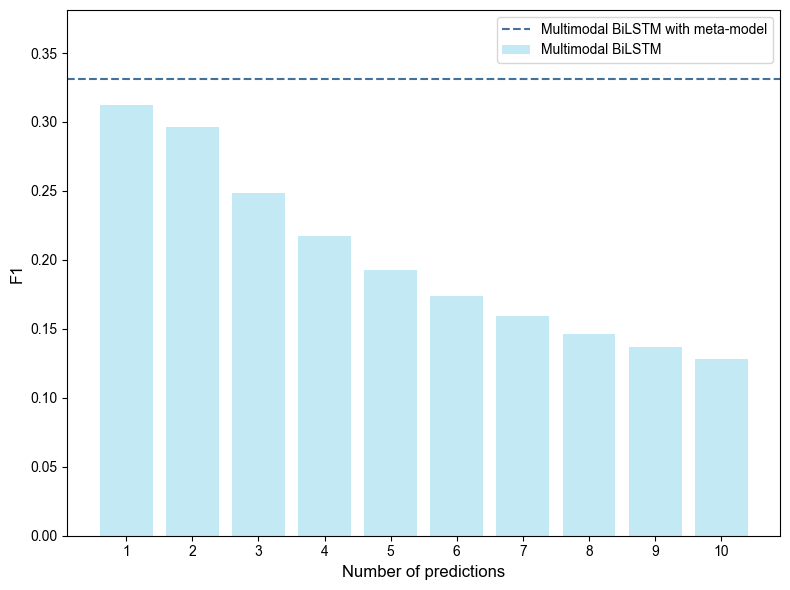

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'

f1_fixed = [average_f11,average_f12, average_f13, average_f14, average_f15, average_f16,average_f17,average_f18,average_f19, average_f110]  
f1_adaptive = average_f1

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = range(len(labels))

plt.figure(figsize=(8, 6))
top_margin = max(max(f1_fixed), f1_adaptive) + 0.05
plt.ylim(0, min(1, top_margin))
plt.bar(x, f1_fixed, label='Multimodal BiLSTM', color='#c3eaf4ff')
plt.axhline(f1_adaptive, color='#42719b', linestyle='--', label='Multimodal BiLSTM with meta-model')

plt.xticks(x, labels)
plt.ylabel('F1', fontdict={'fontname':'Arial', 'fontsize':12})
plt.xlabel('Number of predictions', fontdict={'fontname':'Arial', 'fontsize':12})
plt.legend()
# plt.grid(True, zorder=0, color = "grey", linewidth = "0.5", linestyle = "--")
plt.tight_layout()
filename = f"metamodelF1.png"
plt.savefig(f"metamodelF1.pdf", format="pdf")  
plt.savefig(filename)
plt.show()

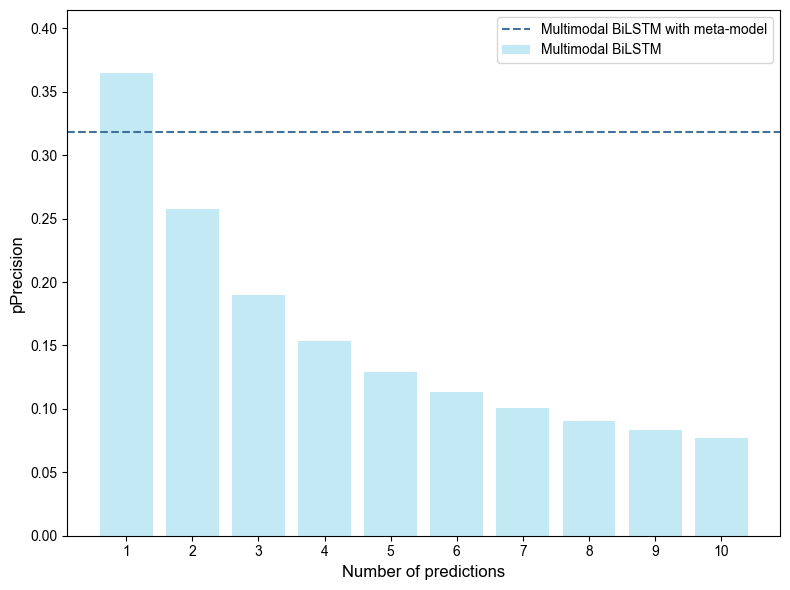

In [60]:
precision_fixed = [average_precision1,average_precision2, average_precision3, average_precision4, average_precision5, average_precision6,average_precision7,average_precision8,average_precision9, average_precision10]  
precision_adaptive = average_precision

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = range(len(labels))

plt.figure(figsize=(8, 6))
top_margin = max(max(precision_fixed), precision_adaptive) + 0.05
plt.ylim(0, min(1, top_margin))
plt.bar(x, precision_fixed, label='Multimodal BiLSTM', color='#c3eaf4ff')
plt.axhline(precision_adaptive, color='#42719b', linestyle='--', label='Multimodal BiLSTM with meta-model')

plt.xticks(x, labels)
plt.ylabel('pPrecision', fontdict={'fontname':'Arial', 'fontsize':12})
plt.xlabel('Number of predictions', fontdict={'fontname':'Arial', 'fontsize':12})
plt.legend()
# plt.grid(True, zorder=0, color = "grey", linewidth = "0.5", linestyle = "--")
plt.tight_layout()
# filename = f"metamodelF1.png"
# plt.savefig(f"metamodelF1.pdf", format="pdf")  
# plt.savefig(filename)
plt.show()

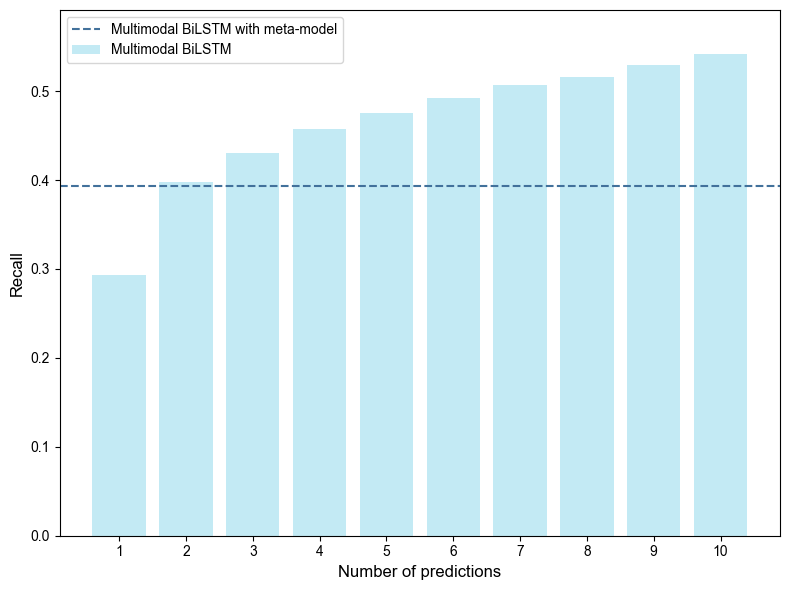

In [61]:
recall_fixed = [average_recall1,average_recall2, average_recall3, average_recall4, average_recall5, average_recall6,average_recall7,average_recall8,average_recall9, average_recall10]  
recall_adaptive = average_recall

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = range(len(labels))

plt.figure(figsize=(8, 6))
top_margin = max(max(recall_fixed), recall_adaptive) + 0.05
plt.ylim(0, min(1, top_margin))
plt.bar(x, recall_fixed, label='Multimodal BiLSTM', color='#c3eaf4ff')
plt.axhline(recall_adaptive, color='#42719b', linestyle='--', label='Multimodal BiLSTM with meta-model')

plt.xticks(x, labels)
plt.ylabel('Recall', fontdict={'fontname':'Arial', 'fontsize':12})
plt.xlabel('Number of predictions', fontdict={'fontname':'Arial', 'fontsize':12})
plt.legend()
# plt.grid(True, zorder=0, color = "grey", linewidth = "0.5", linestyle = "--")
plt.tight_layout()
# filename = f"metamodelF1.png"
# plt.savefig(f"metamodelF1.pdf", format="pdf")  
# plt.savefig(filename)
plt.show()

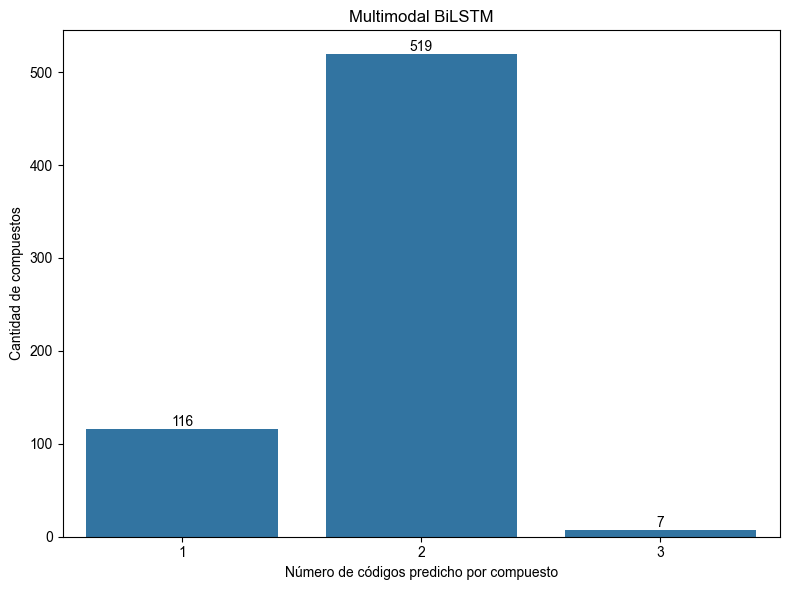

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_pred_int.flatten())
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Número de códigos predicho por compuesto')
plt.ylabel('Cantidad de compuestos')
plt.title('Multimodal BiLSTM')
plt.tight_layout()
plt.show()


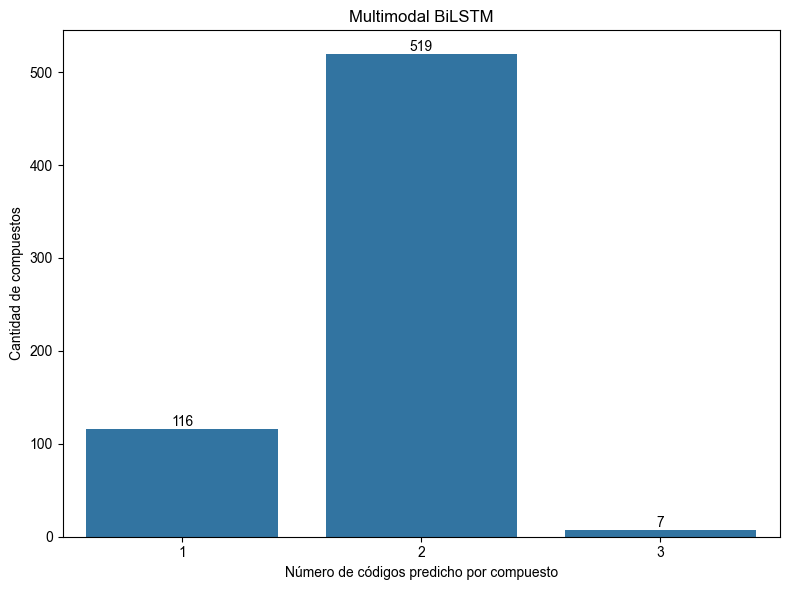

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_pred_int.flatten())
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Número de códigos predicho por compuesto')
plt.ylabel('Cantidad de compuestos')
plt.title('Multimodal BiLSTM')
plt.tight_layout()
plt.show()

A01AC; A07EA; C05AA; D07AA; D07BA; D07CA; D07XA; H02AB; R01AD; S01BA; S01BB; S01CA; S01CB; S02BA; S02CA; S03CA


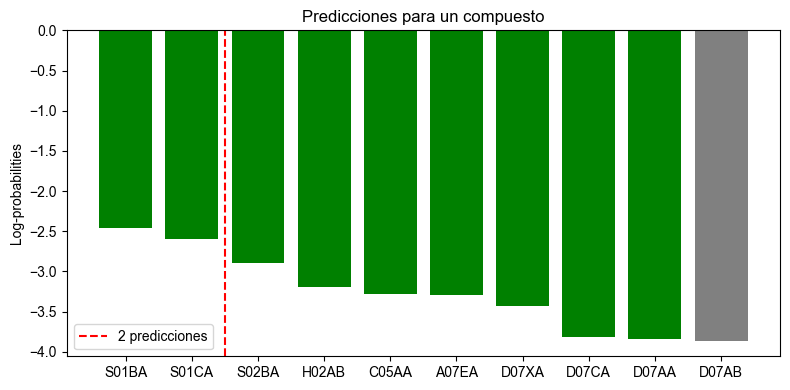

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
val = 79
clean_preds = []
for code in output_beam_test[val]:
    clean_preds.append(code[7:-5])
data = {
    'Código predicho': clean_preds,
    'Log-prob': log_probabilities_test.cpu()[val]
}
df = pd.DataFrame(data)
top_k = y_pred_int.flatten()[val]  # valor predicho por la red para este compuesto
reales = test_set['ATC Codes'][val]

# Gráfico
plt.figure(figsize=(8, 4))
bars = plt.bar(df['Código predicho'], df['Log-prob'], color=['green' if c in reales else 'gray' for c in df['Código predicho']])
print(reales)


plt.axvline(x=top_k - 0.5, color='red', linestyle='--', label=f'{top_k} predicciones')
plt.ylabel('Log-probabilities')
plt.title('Predicciones para un compuesto')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
y_pred_int.flatten()

array([2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [43]:
optimized_output

[['<START>C02AE<END>', '<START>C02BC<END>'],
 ['<START>J01DH<END>'],
 ['<START>P01BC<END>', '<START>P01BF<END>'],
 ['<START>L01AD<END>', '<START>L01AA<END>'],
 ['<START>C02BX<END>', '<START>S01BA<END>'],
 ['<START>S01XX<END>', '<START>M01AX<END>'],
 ['<START>J05AB<END>'],
 ['<START>L05AX<END>', '<START>L05AH<END>'],
 ['<START>N05AX<END>', '<START>L05XX<END>'],
 ['<START>A10BB<END>', '<START>G01AE<END>'],
 ['<START>C03AA<END>', '<START>C03BA<END>'],
 ['<START>A11CC<END>'],
 ['<START>J05AF<END>', '<START>J05AX<END>'],
 ['<START>D01CB<END>', '<START>D01BB<END>'],
 ['<START>N06AX<END>', '<START>N06AB<END>'],
 ['<START>N03AG<END>', '<START>N03AX<END>'],
 ['<START>J05AB<END>', '<START>D06BB<END>'],
 ['<START>C01AX<END>', '<START>H01AX<END>'],
 ['<START>S01CA<END>', '<START>S01BA<END>'],
 ['<START>J05AH<END>'],
 ['<START>N05AD<END>'],
 ['<START>A03BB<END>'],
 ['<START>A11CC<END>'],
 ['<START>B01BB<END>', '<START>B02BB<END>'],
 ['<START>N01AB<END>'],
 ['<START>R06AA<END>', '<START>N06AX<END>']

In [44]:
y

array([1., 1., 1., ..., 1., 0., 2.], dtype=float32)

In [45]:
df = pd.read_csv("test_set.csv")
precisions = []
for i, preds in enumerate(optimized_output):
    ground_truth = convert_string_list(df['ATC Codes'][i])
    print(ground_truth)
    clean_preds = []
    for pred in preds:
        p = pred[7:-5]
        clean_preds.append(p)
    print(clean_preds) 
    binary_predictions = []
    binary_ground_truth = []
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    precisions.append(metrics.precision_score(binary_ground_truth, binary_predictions, zero_division=0.0))

average_prec = sum(precisions) / len(precisions)
print(average_prec)

['S01EA']
['C02AE', 'C02BC']
['J01DH']
['J01DH']
['P01BC']
['P01BC', 'P01BF']
['L01AD']
['L01AD', 'L01AA']
['D06AX', 'D09AA', 'J01XC', 'S01AA']
['C02BX', 'S01BA']
['A01AD', 'R03DX']
['S01XX', 'M01AX']
['A10BD', 'A10BH']
['J05AB']
['L01ED']
['L05AX', 'L05AH']
['A16AX']
['N05AX', 'L05XX']
['A07AB', 'G01AE']
['A10BB', 'G01AE']
['C03AA']
['C03AA', 'C03BA']
['A11CC', 'M05BB', 'M05BX']
['A11CC']
['L03AX']
['J05AF', 'J05AX']
['C02DD']
['D01CB', 'D01BB']
['N06AX']
['N06AX', 'N06AB']
['N02BF', 'N03AX']
['N03AG', 'N03AX']
['D06BB', 'J05AB']
['J05AB', 'D06BB']
['D02BB']
['C01AX', 'H01AX']
['A01AC', 'C05AA', 'D07AB', 'D07BB', 'D07CB', 'D07XB', 'H02AB', 'R01AD', 'R03BA', 'S01BA', 'S02CA']
['S01CA', 'S01BA']
['J05AH']
['J05AH']
['N05AD']
['N05AD']
['A03BB', 'S01FA']
['A03BB']
['D05AX']
['A11CC']
['C05BB']
['B01BB', 'B02BB']
['N01AB']
['N01AB']
['R06AA']
['R06AA', 'N06AX']
['M03BX']
['J01CC']
['G04BE']
['L01EX', 'L01XE']
['M03BC', 'N04AB']
['R06AA', 'D04AA']
['A07AB']
['G01AE', 'A10BB']
['L01EM']
['L

In [46]:
df = pd.read_csv("test_set.csv")
precisions_1pred = []
precisions_2pred = []
precisions_3pred = []
for i, preds in enumerate(optimized_output):
    ground_truth = convert_string_list(df['ATC Codes'][i])
    clean_preds = []
    for pred in preds:
        p = pred[7:-5]
        clean_preds.append(p)
    binary_predictions = []
    binary_ground_truth = []
    set_pred_gt = list(set(clean_preds + ground_truth))
    for code in set_pred_gt:
        if code in clean_preds:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0)
        if code in ground_truth:
            binary_ground_truth.append(1)
        else:
            binary_ground_truth.append(0)    
    if len(clean_preds) == 1:
        precisions_1pred.append(metrics.precision_score(binary_ground_truth, binary_predictions, zero_division=0.0))
    elif len(clean_preds) == 2:
        precisions_2pred.append(metrics.precision_score(binary_ground_truth, binary_predictions, zero_division=0.0))
    else:
        precisions_3pred.append(metrics.precision_score(binary_ground_truth, binary_predictions, zero_division=0.0))
    
average_prec_1pred = sum(precisions_1pred) / len(precisions_1pred)
average_prec_2pred = sum(precisions_2pred) / len(precisions_2pred)
average_prec_3pred = sum(precisions_3pred) / len(precisions_3pred)
print(average_prec_1pred)
print(average_prec_2pred)
print(average_prec_3pred)

0.7241379310344828
0.2302504816955684
0.14285714285714285


In [47]:
predictions_1 = []
predictions_2 = []
predictions_3 = []
gt_1 = []
gt_2 = []
gt_3 = []
for i, preds in enumerate(optimized_output):
    ground_truth = convert_string_list(df['ATC Codes'][i])
    clean_preds = []
    for pred in preds:
        p = pred[7:-5]
        clean_preds.append(p)
    if len(clean_preds) == 1:
        predictions_1.append(clean_preds)
        gt_1.append(ground_truth)
    elif len(clean_preds) == 2:
        predictions_2.append(clean_preds)
        gt_2.append(ground_truth)
    else:
        predictions_3.append(clean_preds)
        gt_3.append(ground_truth)
print(predictions_1)
print(gt_1)

[['J01DH'], ['J05AB'], ['A11CC'], ['J05AH'], ['N05AD'], ['A03BB'], ['A11CC'], ['N01AB'], ['J01CC'], ['C03BA'], ['J05AC'], ['C08CA'], ['N06BA'], ['C10AA'], ['J01DD'], ['J02AC'], ['M01AA'], ['A03BB'], ['C03AA'], ['N06AA'], ['N05BA'], ['N05BA'], ['C02CA'], ['C01DA'], ['J05AB'], ['A03AB'], ['N05AD'], ['J01FA'], ['C08CA'], ['N04AA'], ['N06AA'], ['N06AA'], ['J01MA'], ['N03AX'], ['J05AF'], ['L01DB'], ['C08CA'], ['N06AA'], ['N05BA'], ['J05AB'], ['J02AC'], ['J01DD'], ['L01BB'], ['N05BA'], ['P01AA'], ['N01AB'], ['N06AB'], ['N06AF'], ['N05CA'], ['J05AP'], ['N05BA'], ['L01XX'], ['J01CA'], ['C07AA'], ['N05AD'], ['C07AG'], ['D07AC'], ['N05BA'], ['J01CA'], ['C08CA'], ['N05BA'], ['L01XX'], ['C01BA'], ['C01AA'], ['C01AA'], ['P03AC'], ['C07AA'], ['N06AA'], ['N05CX'], ['N06AB'], ['L01EB'], ['N07AB'], ['J01FA'], ['L01XX'], ['A16AX'], ['J01MB'], ['P01BA'], ['N06AX'], ['J01MA'], ['N05CD'], ['N06AX'], ['A03AB'], ['R03DA'], ['L01BA'], ['N03AD'], ['C01CA'], ['C01BC'], ['A10BG'], ['N06AX'], ['J01CA'], ['M01AA']

In [48]:
for i, preds in enumerate(predictions_2):
    gt = gt_2[i]
    for pred in preds:
        if pred in gt:

SyntaxError: incomplete input (1391067422.py, line 4)

In [ ]:
print(predictions_2)

In [ ]:
print(gt_2)

In [ ]:
print(predictions_3)
print(gt_3)